# Shape Detection

* Lines
* Circle
* Elipse

## RANSAC
It is one of the algorithm for shape detection. RAN - Random, SA - Sampling, C - concesus
![Ransac](../images/ransac.png)

In [1]:
# Randomly sampling of points

import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def f_randomSample(r,c,n):
    '''
    r is row
    c is the column
    n is number of point(s)
    '''
    totalPoints = len(r)
    idx = np.random.permutation(np.arange(totalPoints))
    idx = idx[:n]
    r2,c2 = [],[]
    for i in range(len(idx)):
        r2.append(r[idx[i]])
        c2.append(c[idx[i]])
    return r2,c2

In [3]:
r = np.arange(10)
c = np.arange(10)[::-1]

In [4]:
r

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
c

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [6]:
r2,c2 = f_randomSample(r,c,2)
print(r2,c2)

[7, 3] [2, 6]


In [7]:
r2,c2 = f_randomSample(r,c,9)
print(r2,c2)

[6, 1, 0, 4, 2, 7, 8, 5, 3] [3, 8, 9, 5, 7, 2, 1, 4, 6]


### RANSAC: Line

Equation of line is $y = mx + c$

Assuming y is the `col` and x is the `row`, m = a and c = b. Therefore, $c = ar + b$

if $\begin{bmatrix}r_1 = 2 \\ c_1 = 15\end{bmatrix} and \begin{bmatrix}r_2 = 20 \\ c_2 = 5\end{bmatrix}$

Hence, two equations are formed:
$2a + b = 15 \\ 20a + b = 6$

Solve simulteneously using crammar rule..

$\begin{bmatrix} 2 & 1 \\ 20 & 1\end{bmatrix}\begin{bmatrix} a \\ b\end{bmatrix} = \begin{bmatrix} 15 \\ 6\end{bmatrix}$

${\Large A_x = B}$

Recall from Affine transformation

$X = A^{-1}B$

In [8]:
# Fitting line given 2 points

def f_fitLine(r1,c1,r2,c2):
    # init X so that code doesn't if condition not met
    X = np.array([1,1])
    A = np.array([[r1,1],[r2,1]])
    B = np.array([[c1],[c2]])
    if np.linalg.matrix_rank(A) == 2:
        X = np.linalg.inv(A).dot(B)
    a, b = X[0], X[1]
    return a,b

In [9]:
r = np.arange(10)
c = np.arange(10)[::-1]
r2,c2 = f_randomSample(r,c,2)
a,b = f_fitLine(r2[0],c2[0],r2[1],c2[1])

In [10]:
print(a,b)

[-1.] [9.]


In [11]:
# consistency score implementation

def f_getConsistencyScore(r,c,th,a,b):
    score = 0
    for i in range(len(r)):
        squaredError = (a*r[i] + b - c[i])**2
        if squaredError < th:
            score += 1
    return score

In [12]:
def f_RANSACLine(E):
    E = E > 0
    idx = np.argwhere(E)
    r,c = idx[:,0], idx[:,1]
    best_a, best_b = 0,0
    maxScore = -1
    numIter = 100
    for iter in range(numIter):
        r2,c2 = f_randomSample(r,c,2)
        a, b = f_fitLine(r2[0],c2[0],r2[1],c2[1])
        score = f_getConsistencyScore(r,c,2,a,b)
        if score > maxScore:
            maxScore = score
            best_a,best_b = a,b
    return best_a,best_b

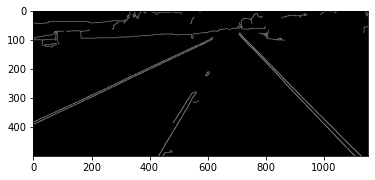

In [13]:
img = plt.imread('../images/E.png')
plt.imshow(img, cmap='gray');

In [14]:
img.shape

(499, 1153, 4)

In [15]:
img = img[:,:,0]

In [16]:
img.shape

(499, 1153)

In [17]:
img.max(), img.min()

(1.0, 0.0)

In [18]:
best_a, best_b = f_RANSACLine(img)

In [19]:
best_a,best_b

(array([-2.09627329]), array([821.00621118]))

In [20]:
# draw the line on img

def f_getExtents(a,b,numRows,numCols):
    r1 = int(0)
    c1 = int(a*r1+b)
    r2 = int(numRows - 1)
    c2 = int(a*r2+b)
    return (c1,r1),(c2,r2)

In [21]:
# s= stating, e = ending
s,e = f_getExtents(best_a,best_b,img.shape[0],img.shape[1])
s,e

((821, 0), (-222, 498))

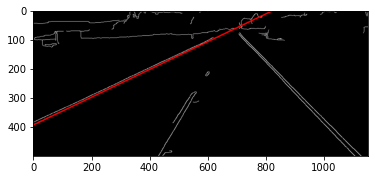

In [22]:
img2 = np.zeros((img.shape[0],img.shape[1],3), dtype=np.uint8)
img3 = np.array(255*img,np.uint8)
img2[:,:,0] = img3
img2[:,:,1] = img3
img2[:,:,2] = img3
I = cv2.line(img2,s,e,(0,0,255),3)
plt.imshow(I[:,:,::-1])

### RANSAC: Circle

![ransac for circle](../images/circle.png)

* For circle, you need 3 non-colinear point to fit a circle.
* Formular for circle $(x-a)^2 + (y-b)^2 = r^2$. x = row, y = col, (a,b) are the center

In [24]:
def f_fitCircle(x1,y1,x2,y2,x3,y3):
    c = (x1-x2)**2 + (y1-y2)**2
    a = (x2-x3)**2 + (y2-y3)**2
    b = (x3-x1)**2 + (y3-y1)**2
    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c)
    px = (a*(b+c-a)+x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3)/s
    py = (a*(b+c-a)+y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3)/s
    ar = a**0.5
    br = b**0.5
    cr = c**0.5
    r = ar*br*cr/((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5
    return px,py,r

In [25]:
def f_getConsistencyScore_circle(x,y,th,a,b,r):
    score = 0
    for i in range(len(x)):
        sd = ((x[i]-a)**2 + (y[i] - b)**2 - r**2)**2
        if sd < th:
            score += 1
    return score

In [56]:
def f_RANSACCircle(E):
    E = E > 0
    idx = np.argwhere(E)
    x,y = idx[:,0], idx[:,1]
    best_a, best_b, best_r = 0,0,0
    maxScore = -1
    numIter = 1000
    for iter in range(numIter):
        r2,c2 = f_randomSample(x,y,3)
        a, b, r = f_fitCircle(r2[0],c2[0],r2[1],c2[1],r2[2],c2[2])
        score = f_getConsistencyScore_circle(x,y,3,a,b,r)
        if score > maxScore:
            maxScore = score
            best_a, best_b, best_r = a,b,r
    return best_a,best_b,best_r

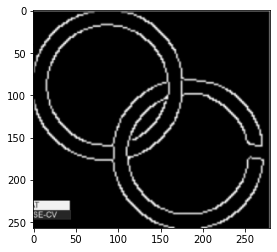

In [57]:
E = plt.imread('../images/E2.png')[:,:,0]
plt.imshow(E, cmap='gray');

In [58]:
E.shape

(257, 280)

In [59]:
E.max(),E.min()

(0.99607843, 0.0)

In [60]:
best_a,best_b,best_r = f_RANSACCircle(E);

In [61]:
best_a, best_b, best_r

(88.65997822364317, 89.62286985911481, 71.27901652043758)

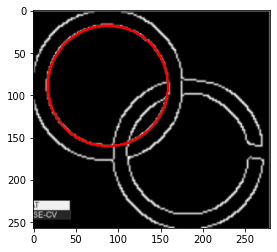

In [62]:
E2 = np.zeros((E.shape[0],E.shape[1],3), dtype=np.uint8)
E3 = np.array(255*E,np.uint8)
E2[:,:,0] = E3
E2[:,:,1] = E3
E2[:,:,2] = E3
I = cv2.circle(E2,(int(best_a),int(best_b)),int(best_r),(0,0,255),2)
plt.imshow(I[:,:,::-1])